In [43]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
from isca_tools.convection.base import lcl_metpy, convection_neutral_profile, dry_profile_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
from geocat.comp.interpolation import interp_hybrid_to_pressure
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [300]:
exp_dir = 'sqe_profile/column/day150/ras_conv/'
# lat = ['0', '23', '50', '70', '90']
lat = ['90']
n_lat = len(lat)
# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+'lat='+lat[0])
# solday = namelist['two_stream_gray_rad_nml']['solday']
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

ds = [isca_tools.load_dataset(exp_dir + f"lat={lat[i]}", decode_times=True).isel(lon=0) for i in range(n_lat)]
ds = xr.concat(ds, dim='lat')
ds = ds.load()

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


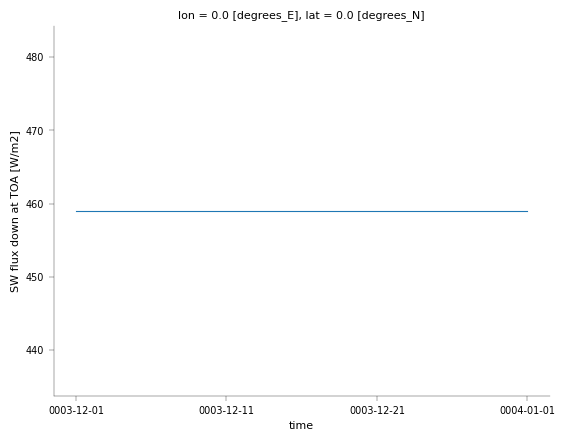

In [301]:
ds.swdn_toa.plot()

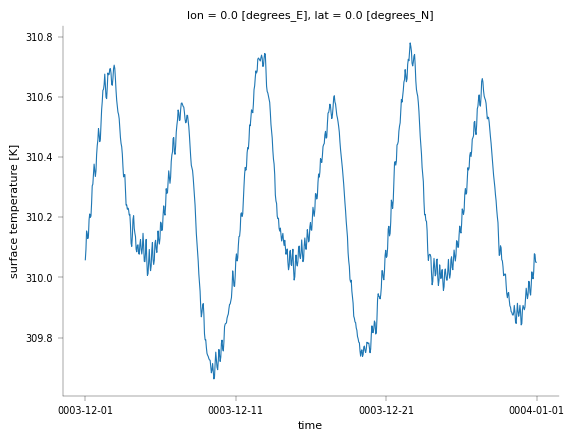

In [302]:
ds.t_surf.plot()

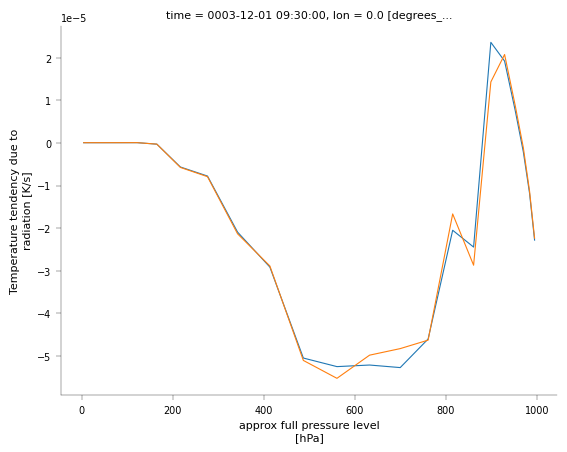

In [303]:
ds.tdt_rad.isel(lat=0, time=0).plot()
ds.tdt_rad.isel(lat=0, time=9).plot()

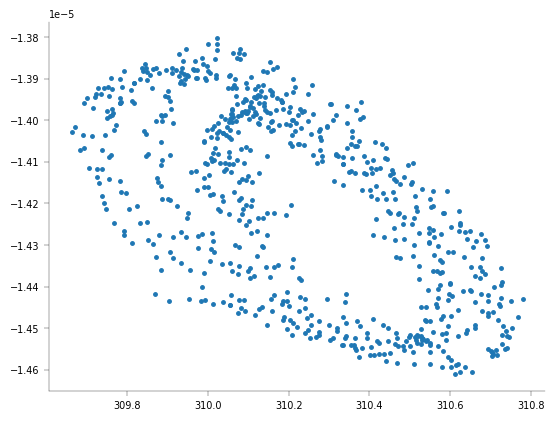

In [304]:
plt.scatter(ds.t_surf.isel(lat=0), ds.tdt_rad.isel(lat=0).mean(dim='pfull'))

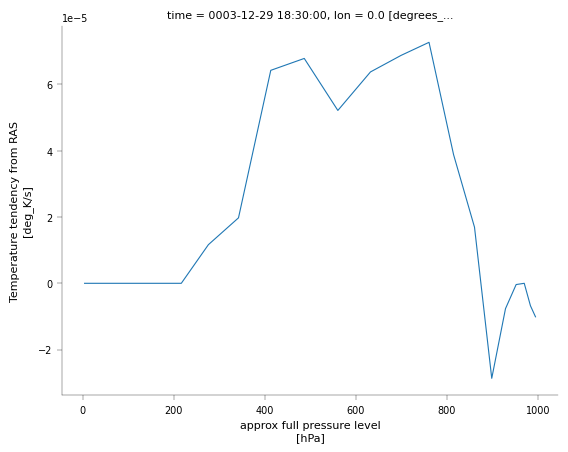

In [305]:
ds.tdt_conv.isel(lat=0, time=-30).plot()

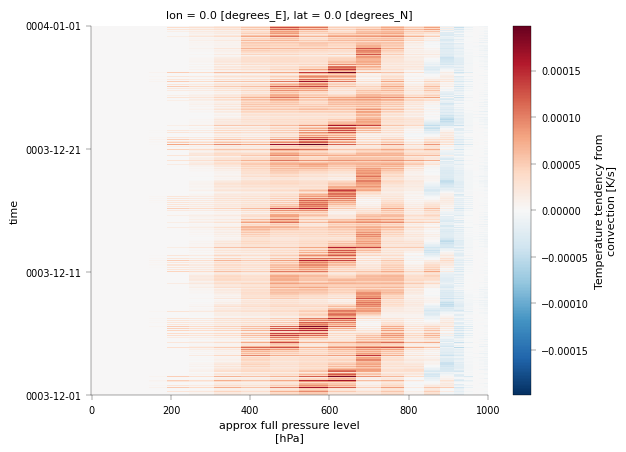

In [306]:
ds.dt_tg_convection.isel(lat=0).plot()

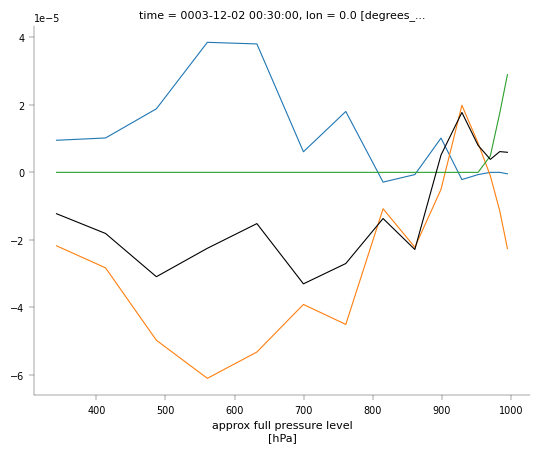

In [307]:
time_ind = 24
ds.dt_tg_convection.isel(lat=0, time=time_ind).sel(pfull=slice(300, 1000)).plot()
ds.tdt_rad.isel(lat=0, time=time_ind).sel(pfull=slice(300, 1000)).plot()
ds.dt_tg_diffusion.isel(lat=0, time=time_ind).sel(pfull=slice(300, 1000)).plot()
(ds.tdt_rad+ds.dt_tg_convection+ds.dt_tg_diffusion).isel(lat=0, time=time_ind).sel(pfull=slice(300, 1000)).plot(color='k')

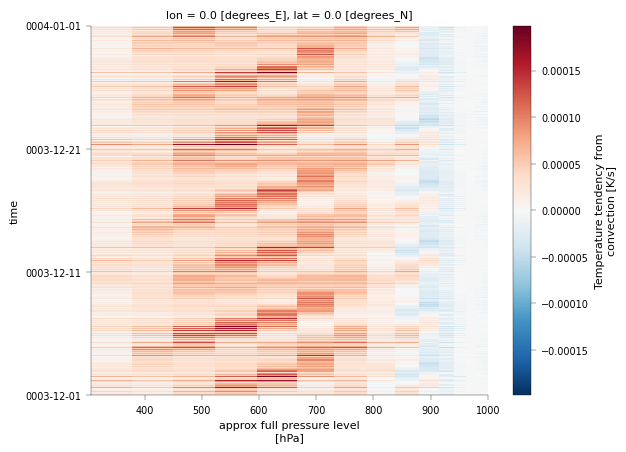

In [308]:
ds.dt_tg_convection.isel(lat=0).sel(pfull=slice(300, 1000)).plot()

In [309]:
ds.bucket_depth

<xarray.DataArray 'bucket_depth' (time: 720, lat: 2)> Size: 6kB
array([[       nan, 0.06897412],
       [       nan, 0.06897425],
       [       nan, 0.06897384],
       ...,
       [       nan, 0.06897506],
       [       nan, 0.06897494],
       [       nan, 0.06897469]], dtype=float32)
Coordinates:
  * time     (time) object 6kB 0003-12-01 00:30:00 ... 0003-12-30 23:30:00
  * lat      (lat) <U6 48B 'base' 'bucket'
    lon      float64 8B 0.0
Attributes:
    long_name:      Depth of surface reservoir
    units:          m
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [241]:
exp_dir = 'sqe_profile/column/day150/'
lat = 90
tau_bm = ['600', '1800', '3600', '7200', '7201']
n_exp = len(tau_bm)
# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+f'lat={lat}_tau_bm={tau_bm[0]}')
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

ds = [isca_tools.load_dataset(exp_dir + f"lat={lat}_tau_bm={tau_bm[i]}", decode_times=True).isel(lon=0) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.DataArray(tau_bm, dims="tau_bm", name="tau_bm"))
ds = ds.load()

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 36 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [309]:
# Get info at 500hPa
pressure_ft = 500 * 100
ds['temp500'] = interp_hybrid_to_pressure(ds.temp, ds.ps, ds.pfull*0, ds.pfull/1000, new_levels=np.asarray([pressure_ft]), lev_dim='pfull')
ds['height500'] = interp_hybrid_to_pressure(ds.height, ds.ps, ds.pfull*0, ds.pfull/1000, new_levels=np.asarray([pressure_ft]), lev_dim='pfull')
ds['mse_2m'] = moist_static_energy(ds.temp_2m, ds.sphum_2m, 2)
ds['mse_sat_500'] = moist_static_energy(ds.temp500, sphum_sat(ds.temp500, pressure_ft), ds.height500)

ds = ds.isel(plev=0).load()

ValueError: x and y must be the same size

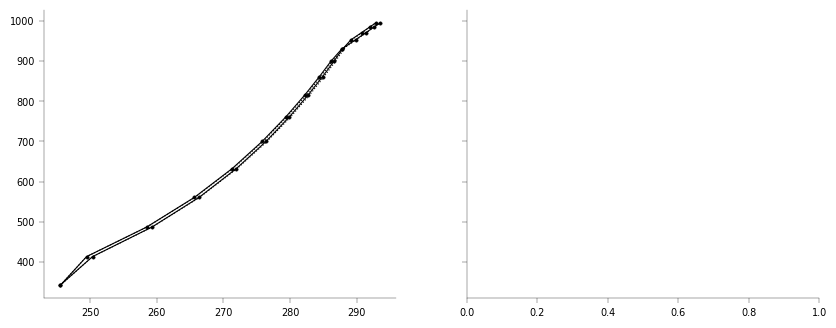

In [311]:
ds_use = ds.isel(time=-1).sel(pfull=slice(300, 1000))
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].plot(ds_use.temp, ds_use.pfull, color='k', marker='o', label='$T_{env}$')
ax[0].plot(ds_use.t_ref, ds_use.pfull, linestyle=':', color='k', label='$T_{SQE}$')
ax[0].scatter(ds_use.t_surf, 1000, color='C2', marker='|', s=300, lw=2)
ax[0].invert_yaxis()
ax[1].plot(ds_use.dt_tg_convection, ds_use.pfull, color='C0', label='Convection')
ax[1].plot(ds_use.tdt_rad, ds_use.pfull, color='C1', label='Radiation')
# ax[1].plot(ds_use.tdt_solar, ds_use.pfull, color='C1', linestyle=':', label='Radiation (just solar)')
ax[1].plot(ds_use.dt_tg_diffusion, ds_use.pfull, color='C2', label='Diffusion')
ax[1].plot(ds_use.dt_tg_diffusion + ds_use.tdt_rad + ds_use.dt_tg_convection, ds_use.pfull, color='k', label='Sum')
ax[0].set_ylim(1000, 300)
ax[0].legend()
ax[1].legend()
plt.show()

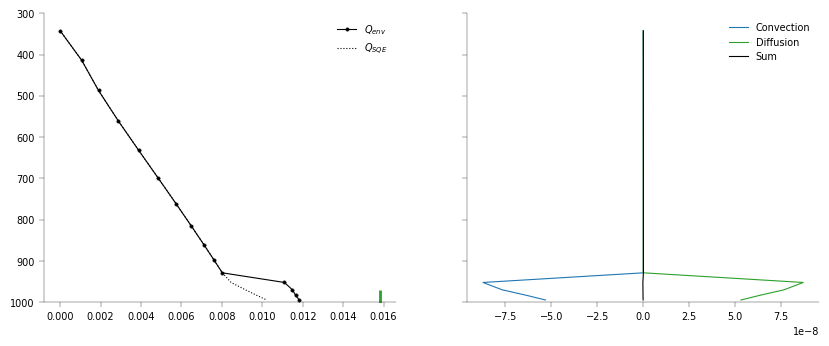

In [330]:
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].plot(ds_use.sphum, ds_use.pfull, color='k', marker='o', label='$Q_{env}$')
ax[0].plot(ds_use.q_ref, ds_use.pfull, linestyle=':', color='k', label='$Q_{SQE}$')
ax[0].scatter(sphum_sat(ds_use.t_surf, 1000*100), 1000, color='C2', marker='|', s=300, lw=2)
# ax[0].scatter(ds_use.sphum_2m, 1000, color='C2', marker='|', s=300, lw=2)
ax[0].invert_yaxis()
ax[1].plot(ds_use.dt_qg_convection, ds_use.pfull, color='C0', label='Convection')
ax[1].plot(ds_use.dt_qg_diffusion, ds_use.pfull, color='C2', label='Diffusion')
ax[1].plot(ds_use.dt_qg_diffusion + ds_use.dt_qg_convection, ds_use.pfull, color='k', label='Sum')
ax[0].set_ylim(1000, 300)
ax[0].legend()
ax[1].legend()
plt.show()

In [281]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['pfull']],
                          output_core_dims=[['pfull']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    # if np.isnan(temp_lcl):
    #     return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

In [310]:
ds_use = ds.where(ds.time.dt.day == 25, drop=True).sel(pfull=slice(100, 1000)).isel(lat=0)

ds_use['p_lcl'], ds_use['temp_lcl'] = lcl_metpy(ds_use.temp_2m, ds_use.sphum_2m, ds_use.ps)
ds_use['temp_sqe'] = apply_func_vec(conv_neutral_profile, ds.pfull*100, ds_use['temp_lcl'], ds_use['p_lcl'])

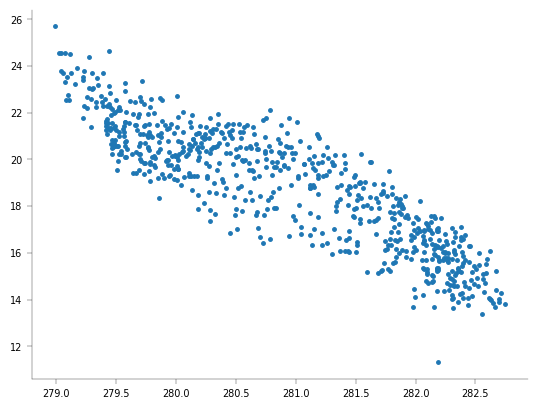

In [316]:
plt.scatter(ds.temp.sel(pfull=500, method='nearest'), (ds.mse_2m -ds.mse_sat_500))

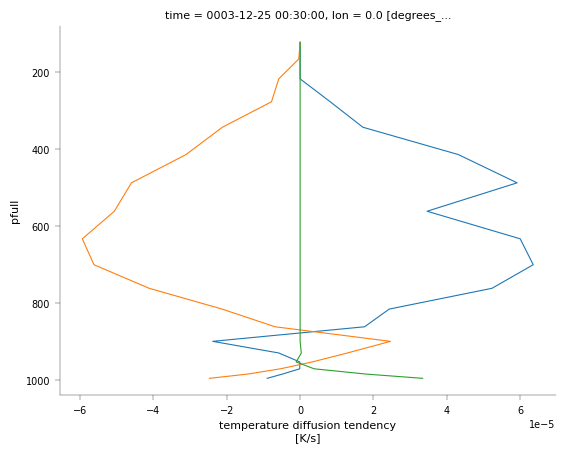

In [312]:
# ds_use.tdt_rad.isel(time=-1).plot(y='pfull')
ds_use.dt_tg_convection.isel(time=0).plot(y='pfull')
ds_use.tdt_rad.isel(time=0).plot(y='pfull')
ds_use.dt_tg_diffusion.isel(time=0).plot(y='pfull')
plt.gca().invert_yaxis()

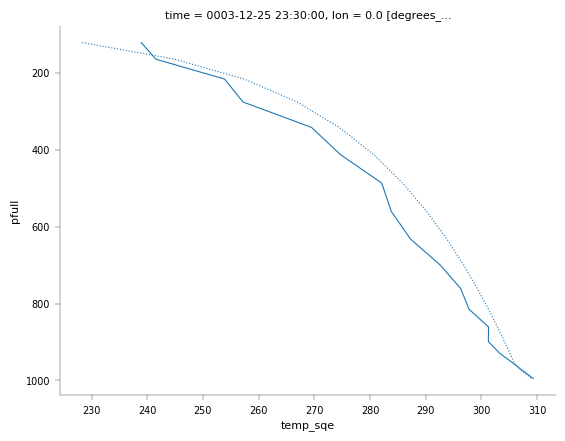

In [313]:
ds_use.temp.isel(time=-1).plot(y='pfull')
ds_use.temp_sqe.isel(time=-1).plot(y='pfull', linestyle=':', c='C0')
# ds_use.temp.isel(time=0).plot(y='pfull')
# ds_use.temp_sqe.isel(time=0).plot(y='pfull')
plt.gca().invert_yaxis()

In [314]:
for i in range(ds_use.tau_bm.size):
    plt.plot(ds_use.isel(time=12, tau_bm=i).temp, ds_use.pfull, color=f'C{i}')
    plt.plot(ds_use.isel(time=12, tau_bm=i).temp_sqe, ds_use.pfull, linestyle=':', color=f'C{i}')
    plt.plot(ds_use.isel(time=12, tau_bm=i).t_ref, ds_use.pfull, linestyle='--', color=f'C{i}')
plt.gca().invert_yaxis()

AttributeError: 'Dataset' object has no attribute 'tau_bm'

In [141]:
ds_use = ds.isel(time=19, lat=1).sel(pfull=slice(300, 1000))
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].plot(ds_use.temp, ds_use.pfull, color='k', marker='o', label='$T_{env}$')
ax[0].plot(ds_use.t_ref, ds_use.pfull, linestyle=':', color='k', label='$T_{SQE}$')
ax[0].scatter(ds_use.t_surf, 1000, color='C2', marker='|', s=300, lw=2)
ax[0].invert_yaxis()
ax[1].plot(ds_use.dt_tg_convection, ds_use.pfull, color='C0', label='Convection')
ax[1].plot(ds_use.tdt_rad, ds_use.pfull, color='C1', label='Radiation')
# ax[1].plot(ds_use.tdt_solar, ds_use.pfull, color='C1', linestyle=':', label='Radiation (just solar)')
ax[1].plot(ds_use.dt_tg_diffusion, ds_use.pfull, color='C2', label='Diffusion')
ax[1].plot(ds_use.dt_tg_diffusion + ds_use.tdt_rad + ds_use.dt_tg_convection, ds_use.pfull, color='k', label='Sum')
ax[0].set_ylim(1000, 300)
ax[0].legend()
ax[1].legend()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [255]:
namelist['two_stream_gray_rad_nml']['solday']

150

In [249]:
for i in range(1, 4):
    # (ds_use.mse_2m - ds_use.mse_sat_500).isel(tau_bm=i).plot(color=f"C{i}")
    (ds_use.cape/100).isel(tau_bm=i).plot(color=f"C{i}")
    ds_use.convflag.isel(tau_bm=i).plot(color=f"C{i}", linestyle=':')
# (ds_use.mse_2m - ds_use.mse_sat_500).isel(tau_bm=2).plot()
# ds_use.convflag.isel(tau_bm=2).plot()

ValueError: Dimensions {'tau_bm'} do not exist. Expected one or more of ('lat',)

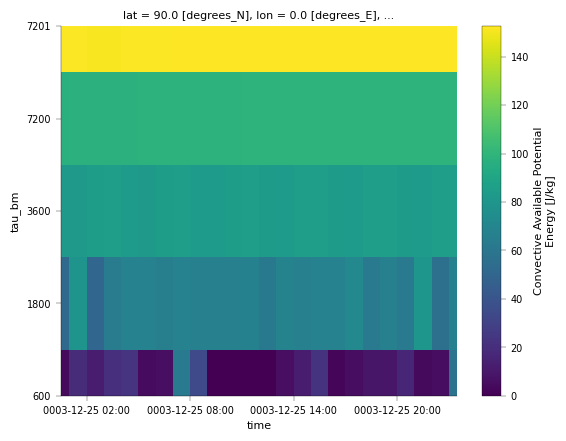

In [252]:
ds_use.cape.plot()

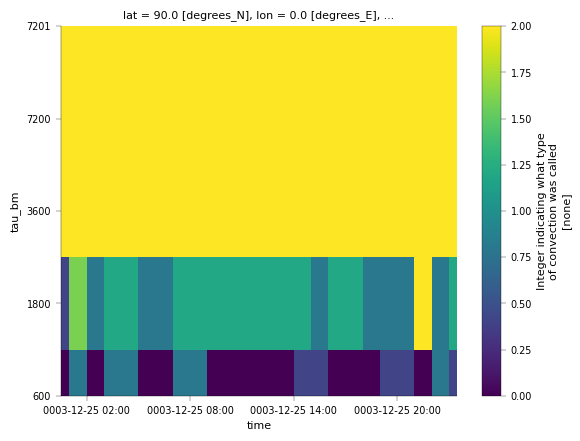

In [253]:
ds_use.convflag.plot()

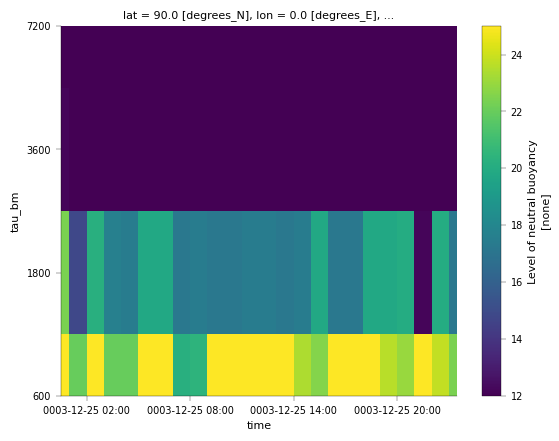

In [227]:
ds_use.klzbs.plot()

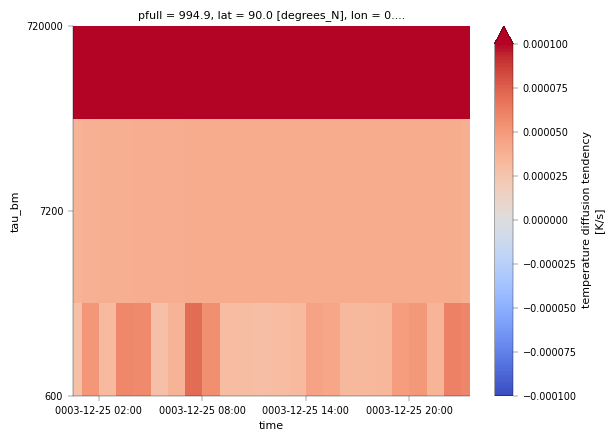

In [123]:
ds_use.dt_tg_diffusion.isel(pfull=-1).plot(vmax=1e-4, vmin=-1e-4, cmap='coolwarm')

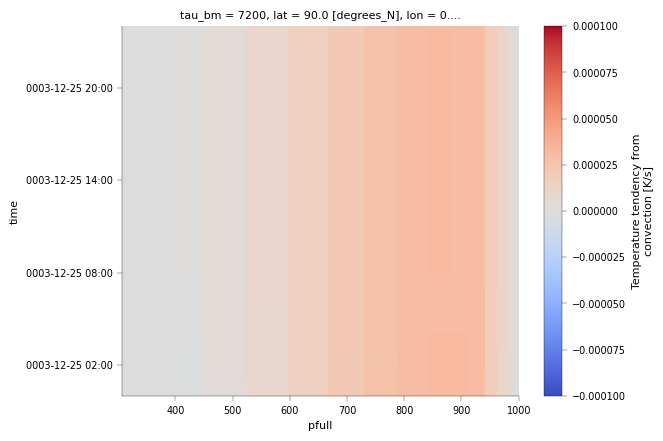

In [240]:
ds_use.dt_tg_convection.isel(tau_bm=3).plot(vmax=1e-4, vmin=-1e-4, cmap='coolwarm')

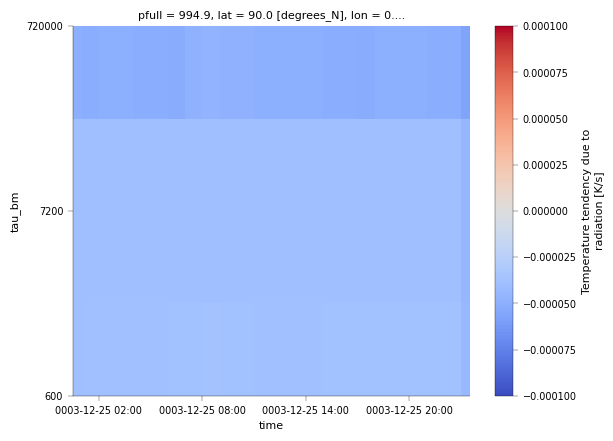

In [127]:
ds_use.tdt_rad.isel(pfull=-1).plot(vmax=1e-4, vmin=-1e-4, cmap='coolwarm')

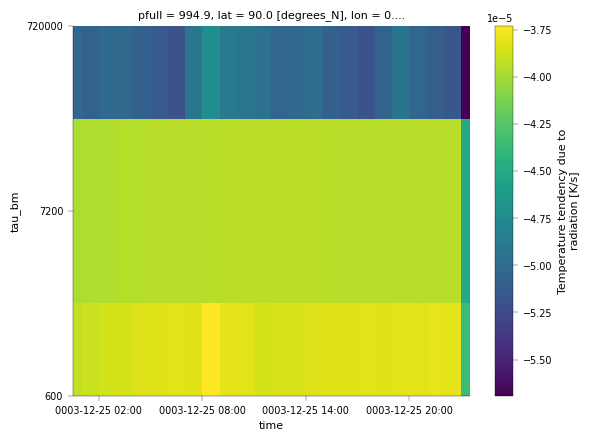

In [128]:
ds_use.tdt_rad.isel(pfull=-1).plot()

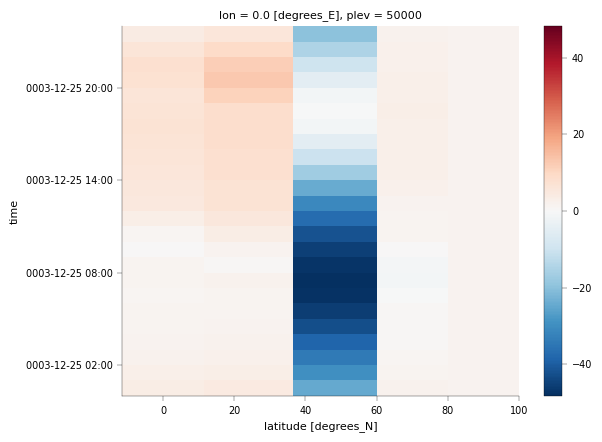

In [171]:
(ds_use.mse_2m-ds_use.mse_sat_500).plot()

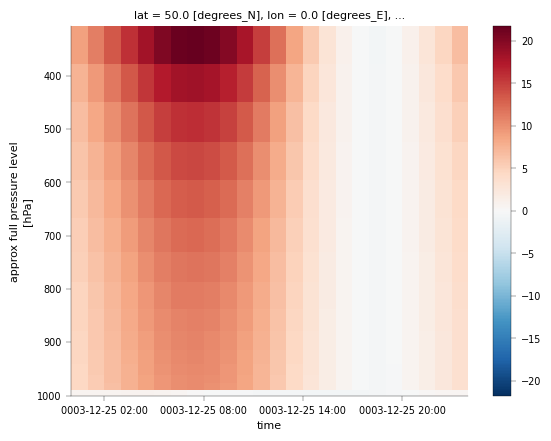

In [173]:
(ds_use.temp-temp_sqe).transpose().isel(lat=2).plot()
plt.gca().invert_yaxis()

In [24]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['pfull']],
                          output_core_dims=[['pfull']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    # if np.isnan(temp_lcl):
    #     return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

In [25]:
p_lcl, temp_lcl = lcl_metpy(ds_use.temp_2m, ds_use.sphum_2m, ds_use.ps)
temp_sqe = apply_func_vec(conv_neutral_profile, ds.pfull*100, temp_lcl, p_lcl)

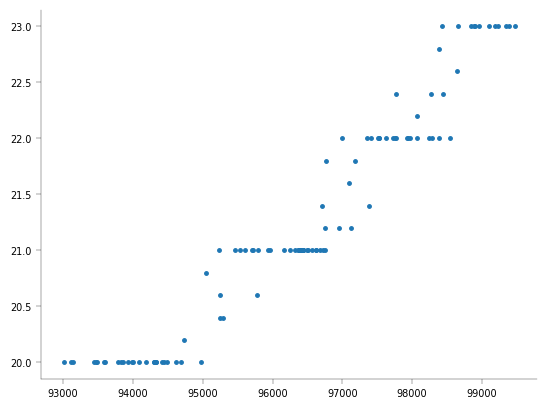

In [11]:
plt.scatter(p_lcl, ds_use.klcls)

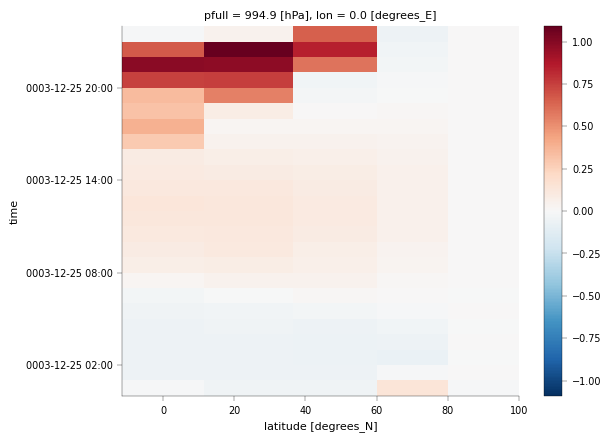

In [69]:
(ds_use.temp-ds_use.t_ref).isel(pfull=-1).plot()

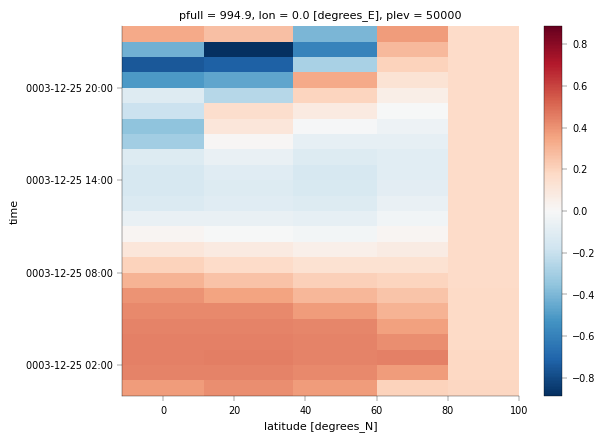

In [119]:
(ds_use.t_ref-temp_sqe).isel(pfull=-1).plot()

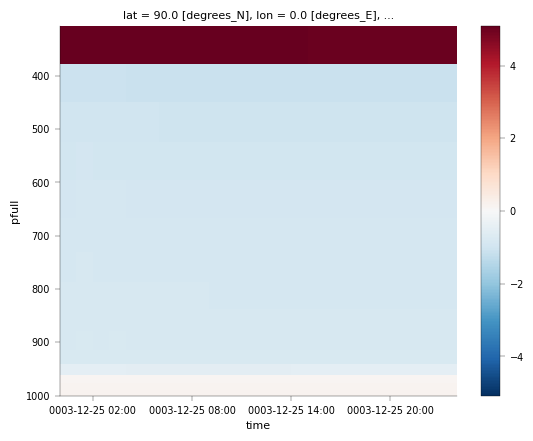

In [124]:
(ds_use.temp-temp_sqe).transpose().isel(lat=4).plot()
plt.gca().invert_yaxis()

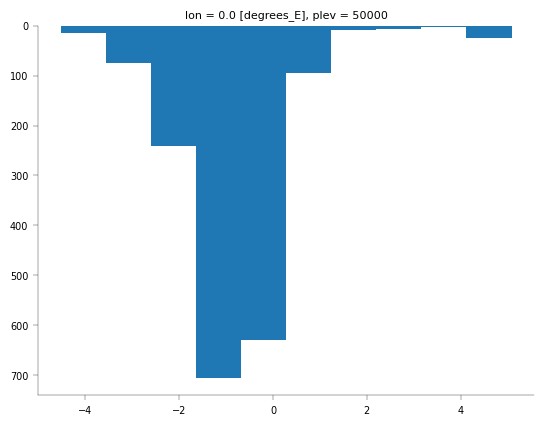

In [111]:
(ds_use.temp-ds_use.t_ref).transpose().plot()
plt.gca().invert_yaxis()

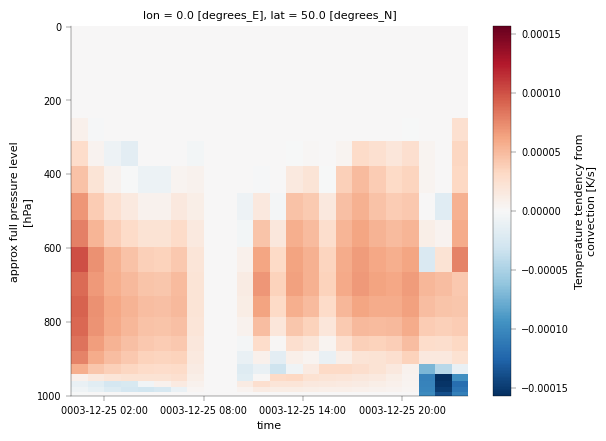

In [147]:
ds_use.dt_tg_convection.transpose().plot()
plt.gca().invert_yaxis()

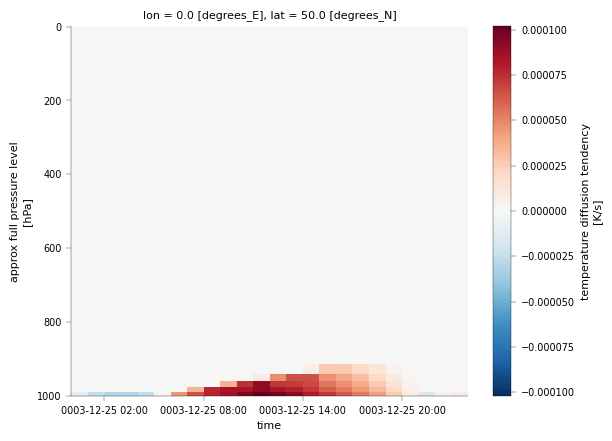

In [148]:
ds_use.dt_tg_diffusion.transpose().plot()
plt.gca().invert_yaxis()

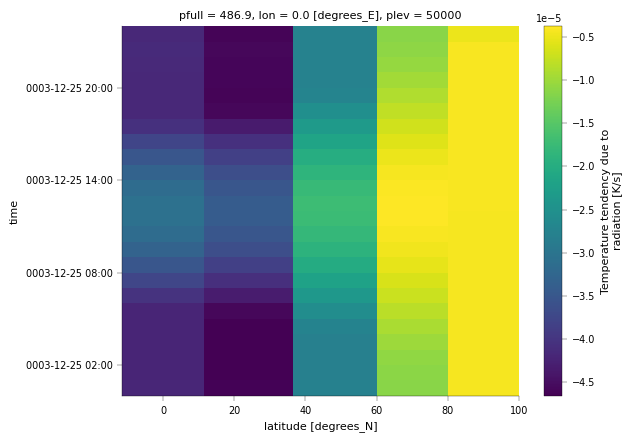

In [127]:
ds_use.tdt_rad.sel(pfull=500, method='nearest').plot()
# plt.gca().invert_yaxis()

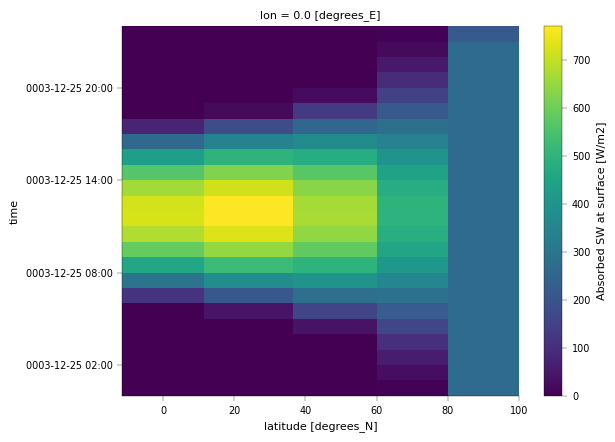

In [17]:
ds_use.swdn_sfc.plot()

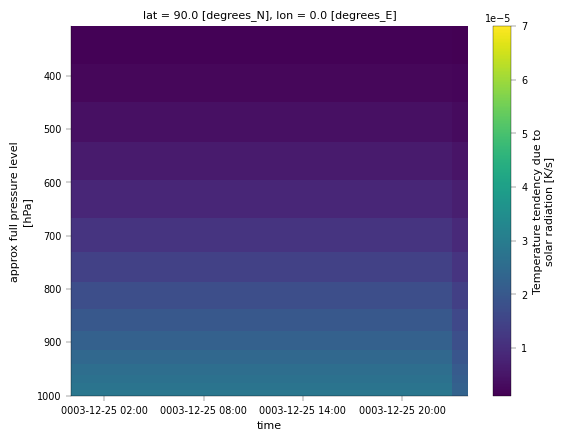

In [52]:
ds_use.tdt_solar.transpose().isel(lat=4).plot(vmax=7e-5)
plt.gca().invert_yaxis()

In [323]:
ds.klzbs

<xarray.DataArray 'klzbs' (time: 720, lat: 2)> Size: 6kB
array([[12., 12.],
       [12., 12.],
       [12., 12.],
       ...,
       [12., 12.],
       [12., 12.],
       [12., 12.]], dtype=float32)
Coordinates:
  * time     (time) object 6kB 0003-12-01 00:30:00 ... 0003-12-30 23:30:00
  * lat      (lat) <U6 48B 'base' 'bucket'
    lon      float64 8B 0.0
    plev     int64 8B 50000
Attributes:
    long_name:      Level of neutral buoyancy
    units:          none
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [321]:
ds_use.klzbs.plot()
# ds_use.klcls.plot()

TypeError: No numeric data to plot.

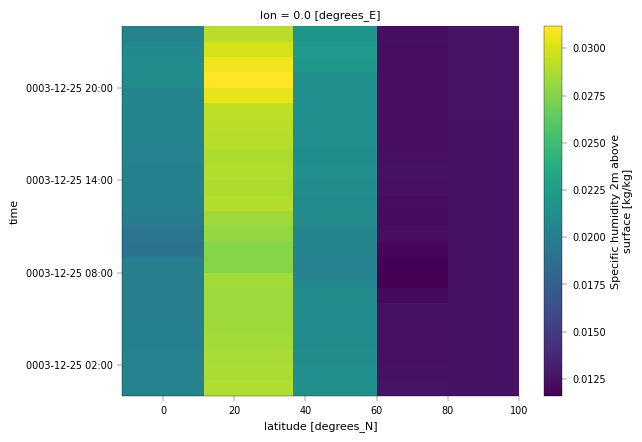

In [60]:
ds_use.sphum_2m.plot()

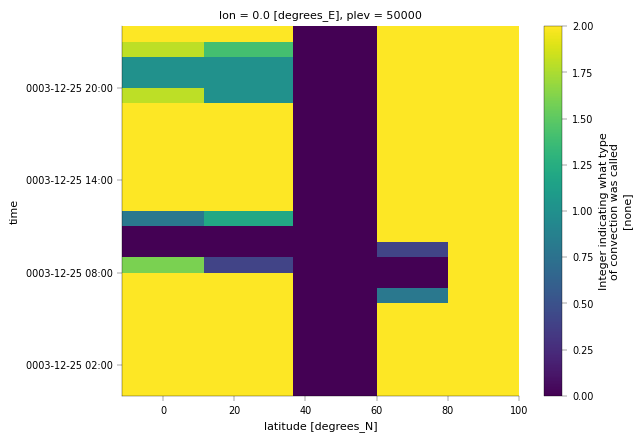

In [166]:
ds_use.convflag.plot()

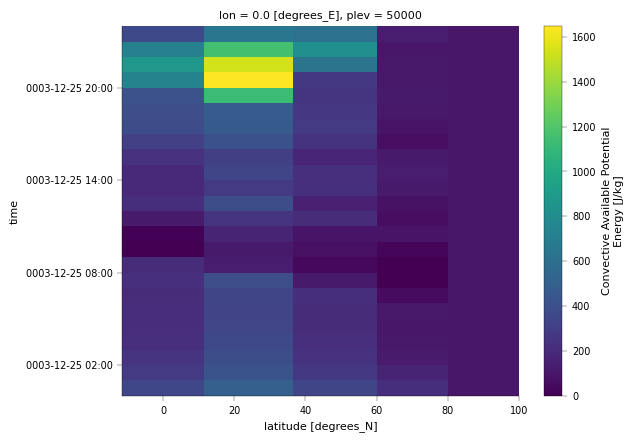

In [17]:
ds_use.cape.plot()
# ds_use.cin.plot()

In [199]:
ds_use.isel(lat=2).t_surf.argmax()

<xarray.DataArray 't_surf' ()> Size: 8B
array(16)
Coordinates:
    lat      float64 8B 50.0
    lon      float64 8B 0.0
    plev     int64 8B 50000

(250.0, 300.0)

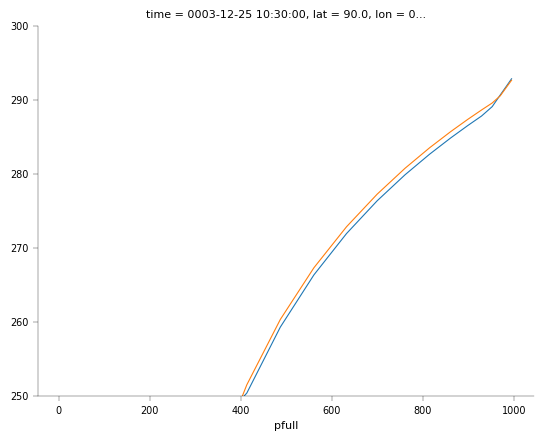

In [27]:
ds_use.isel(lat=-1, time=19).temp.plot()
# ds_use.isel(lat=2, time=1).temp.plot()
temp_sqe.isel(lat=-1, time=10).plot()
plt.ylim(250, 300)

In [ ]:
mse_2m = moist_static_energy(ds_use.temp_2m, ds_use.sphum_2m, 2)
mse_sat_500 =